In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F

import csv
import time
import pandas as pd


In [3]:
!nvidia-smi

Wed Feb 12 09:00:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
raw_data_folder = "/content/drive/MyDrive/sat_classifyer/data/EuroSAT_RGB"
paths = ["/content/drive/MyDrive/sat_classifyer_pytorch/data/train", "/content/drive/MyDrive/sat_classifyer_pytorch/data/test"]
class_list = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [18]:
#split data into train and test

for folder in paths:
    for class_ in class_list:
        directory = os.path.join(folder, class_)
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"{directory} created.")
        else:
          print(f"{directory} already existed.")


np.random.seed(1)
class_dict = {}
for class_ in class_list:
    images = os.listdir(os.path.join(raw_data_folder, class_))
    class_dict.update(dict.fromkeys(images, class_))

    list_train, list_test = train_test_split(images, test_size=0.2, random_state=1)
    print (class_)
    for image in list_train:
        shutil.copyfile(os.path.join(raw_data_folder, class_, image),os.path.join(paths[0], class_, image))
    for image in list_test:
        shutil.copyfile(os.path.join(raw_data_folder, class_, image),os.path.join(paths[1], class_, image))


/content/drive/MyDrive/sat_classifyer_pytorch/data/train/AnnualCrop already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Forest already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/HerbaceousVegetation already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Highway already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Industrial already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Pasture already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/PermanentCrop already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/Residential already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/River already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/train/SeaLake already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/test/AnnualCrop already existed.
/content/drive/MyDrive/sat_classifyer_pytorch/data/test/Forest already

In [7]:
#train and test data directory
train_data_dir = paths[0]
test_data_dir = paths[1]


#load the train and validation data
train_dataset = ImageFolder(train_data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [8]:
img, label = train_dataset[0]
print(img.shape,label)

#output :
#torch.Size([3, 150, 150]) 0

torch.Size([3, 150, 150]) 0


In [9]:
print("Follwing classes are there : \n", train_dataset.classes)

#output:
#Follwing classes are there :
# ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

Follwing classes are there : 
 ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Label : AnnualCrop


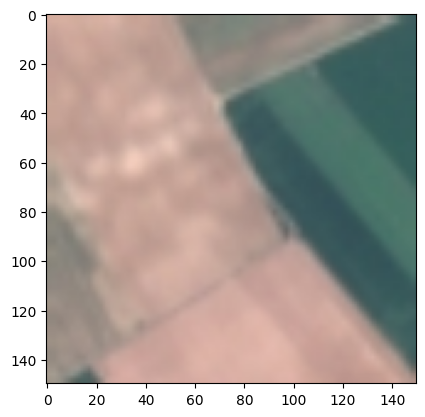

In [10]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[0])

Label : AnnualCrop


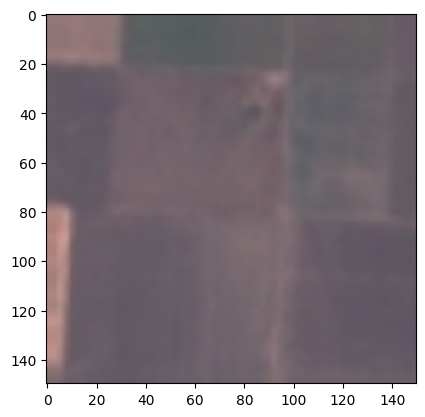

In [11]:
#display the first image in the dataset
display_img(*test_dataset[0])

In [12]:
batch_size = 128
val_size = int(np.round(0.2 * len(train_dataset)))
train_size = len(train_dataset) - val_size

print(val_size)

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation data into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

4323
Length of Train Data : 17294
Length of Validation Data : 4323


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


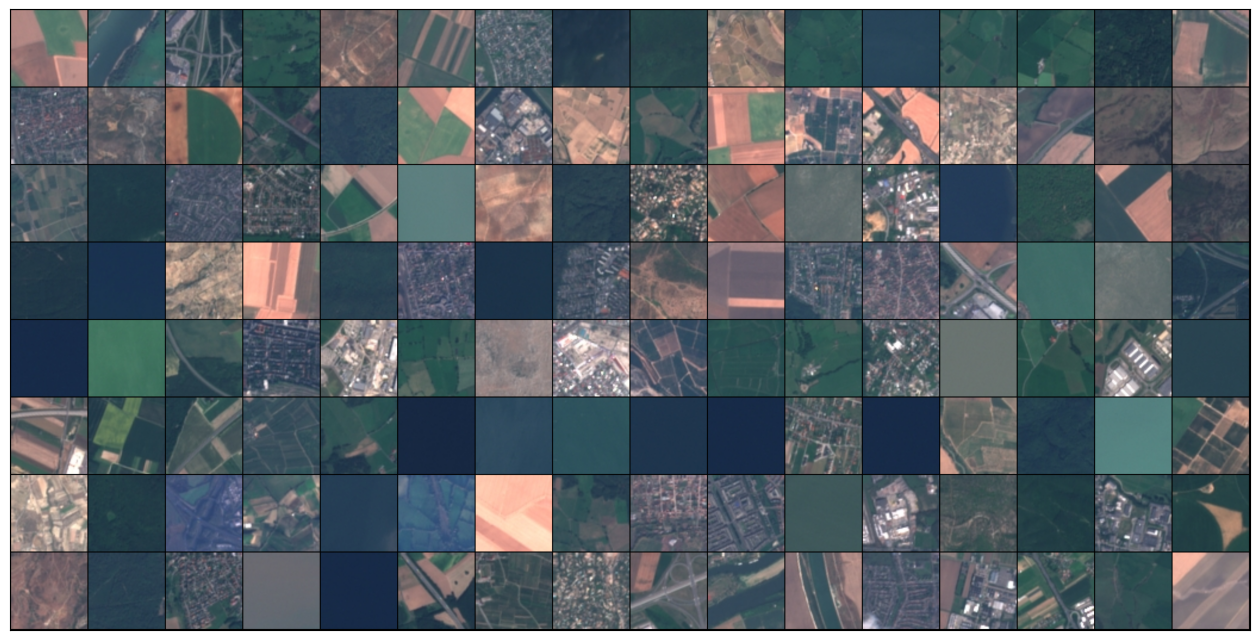

In [35]:
#visualize a batch of images

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

In [13]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result, epoch_time):
        print("Epoch [{}], time: {}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, epoch_time, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
class SatelliteClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,len(train_dataset.classes))
        )

    def forward(self, xb):
        return self.network(xb)

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, checkpoint_path = "best_model.pth", opt_func = torch.optim.SGD):

    history = []
    best_loss = float('inf')
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        # Save the best model checkpoint
        if result["val_loss"] < best_loss:
            best_loss = result["val_loss"]
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1} with validation loss {best_loss:.4f}")
        epoch_time = time.time() - start_time
        model.epoch_end(epoch, result, epoch_time)
        history.append(result)

    return history

In [16]:
model = SatelliteClassification()
model

SatelliteClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linea

In [23]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)


In [24]:
# load data into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
# deploy model to GPU
to_device(model, device)



SatelliteClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linea

In [ ]:
#load the model to the device
model = to_device(SatelliteClassification(),device)



In [ ]:
evaluate(model,val_dl)

In [25]:
# train and save model and statistics
start = time.time()
output_path = "/content/drive/MyDrive/sat_classifyer_pytorch/120225"
model_name = "120225.pth"
train_from_scratch = True
num_epochs = 5
opt_func = torch.optim.Adam
learning_rate = 0.001
checkpoint_path = os.path.join(output_path, model_name)

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, learning_rate, model, train_dl, val_dl, checkpoint_path, opt_func)

# # convert the history.history dict to a pandas DataFrame:
# lossData = pd.DataFrame(history.history)

#check whether qc file exist, and whether is should be extended or removed
qc_path = os.path.join(output_path, "/Quality Control")
if os.path.exists(qc_path) and train_from_scratch:
  shutil.rmtree(qc_path)
  os.makedirs(qc_path)
elif os.path.exists(qc_path) and train_from_scratch == False:
  extend_csv = True
if not os.path.exists(qc_path):
  os.makedirs(qc_path)

lossDataCSVpath = os.path.join(qc_path, 'training_evaluation.csv')
if extend_csv:
  #read and extend existing file
  with open(lossDataCSVpath, 'ab') as f:
    writer = csv.writer(f)
    writer.writerow(['loss','val_loss', 'learning rate'])
    for i in range(len(history.history['loss'])):
      writer.writerow([history.history['loss'][i], history.history['val_loss'][i], learning_rate])

else:
  # The training evaluation.csv is created and saved
  with open(lossDataCSVpath, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['loss','val_loss', 'learning rate'])
    for i in range(len(history.history['loss'])):
      writer.writerow([history.history['loss'][i], history.history['val_loss'][i], learning_rate])

# Displaying the time elapsed for training
dt = time.time() - start
mins, sec = divmod(dt, 60)
hour, mins = divmod(mins, 60)
print("Time elapsed:",hour, "hour(s)",mins,"min(s)",round(sec),"sec(s)")

KeyboardInterrupt: 

In [22]:
device = get_default_device()
device

device(type='cuda')

In [ ]:


def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:

torch.save(model.state_dict(), '/content/drive/MyDrive/sat_classifyer_pytorch/SatelliteClassification.pth')

In [ ]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]